# LU Decomposition and the PageRank Algorithm

Preamble: Run the cells below to import the necessary Python packages

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lu_decomposition.ipynb) -->
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/lu_decomposition.ipynb)

In [1]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Revisiting the coauthorship graph

We previously considered the coauthorship graph among physicists based arXiv postings in `astro-ph`. The graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003. If Author i and Author j coauthored a paper during that period, their nodes are connected. In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors.


This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)



In [2]:
import io
import gzip
import urllib.request
import networkx as nx

# subject = "CondMat"
# subject = "HepPh"
# subject = "HepTh"
# subject = "GrQc"
subject = "AstroPh"
url = f"https://snap.stanford.edu/data/ca-{subject}.txt.gz"

with urllib.request.urlopen(url) as resp:
    with gzip.open(io.BytesIO(resp.read()), mode="rt") as fh:
        g = nx.read_edgelist(fh, comments="#", nodetype=int)

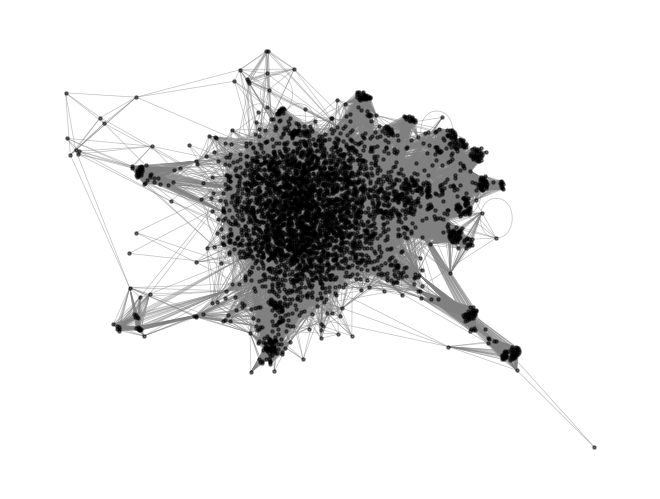

In [3]:
## Create a subgraph of the 1000 most well-connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

## Estimating degree distributions, centrality, and the PageRank algorithm


We previously saw that the degree distribution determines how often a random walk on the graph will visit a given node. This can be seen an an indicator of how "important" a given node is to the structure of the graph. If we wanted to rank the authors purely based on their degree distribution, we could write this ranking as 
$$
\mathbf{R} = A  \mathbb{1}
$$
where $\mathbb{1} \in \mathbb{R}^N$ is a vector of ones, $A \in \mathbb{R}^{N\times N}$ is our adjacency matrix, and $\mathbf{R} \in \mathbb{R}^N$ is our desired ranking. Notice how the matrix product with the ones vector allows us to compute the rowwise sum. This makes sense, because we expect that this operation should take $N^2$ operations, and matrix-vector products are $N^2$.

<!-- + Random walk based algorithms can be very useful for finding important nodes in cases where we don't have access to the full adjacency matrix $A$, or the matrix is too big to analyze all at once. We can instead use a set of random hops among nodes to estimate the degree distribution

+ Our random walk estimator is reminiscent of other problems in computational physics, where we need to estimate statistical invariants based on local sampling. For example, we often estimate the partition function of a system by sampling the local energy of the system with Monte Carlo methods. In optimization, we often estimate the gradient of a function by sampling the function locally. -->

<!-- + Search engines use a very similar process to rank web pages. The PageRank algorithm originally used by Google is a variant of the random walk algorithm. It samples and ranks the major websites (nodes) by simulating the dynamics of a "random surfer" who clicks on links on a given web page at random. 

+ However, unlike our random walk example, the PageRank algorithm assumes that the surfer will sometimes randomly jump to a new page with probability $1 - \alpha$. This is a model for the fact that a user might randomly type a new URL into their browser, or click on a bookmark, rather than clicking on a link on the current page. In practice, this helps the algorithm more quickly discover subnetworks of the graph, which would otherwise take a long time to find. -->

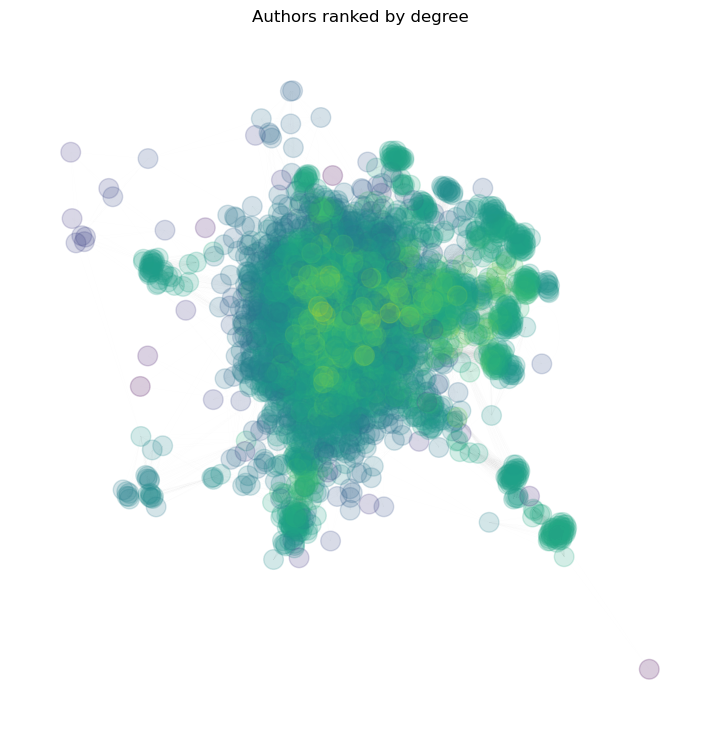

Text(0.5, 0, 'Degree')

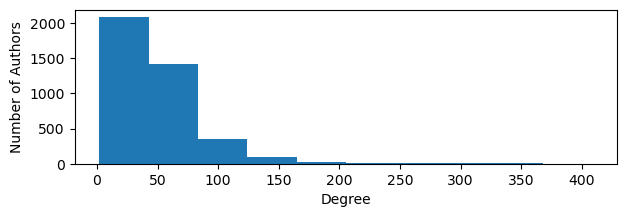

In [4]:
A = nx.adjacency_matrix(g2).todense() # get the binary adjacency matrix of the graph
rank_degree = A @ np.ones(A.shape[0])

plt.figure(figsize=(7, 7))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(rank_degree), edge_color='gray', width=0.01, cmap='viridis', alpha=0.2)
plt.title(f"Authors ranked by degree")
plt.show()

plt.figure(figsize=(7, 2))
plt.hist(rank_degree)
plt.ylabel("Number of Authors")
plt.xlabel("Degree")

## How else might we group authors?

The degree ranking simply tells use who are the most well-connected authors are. They are the individuals who directly co-authored a paper with someone else at any point during the period over which the arXiv dataset was collected. 


 Recall that we can think of the degree distribution as the long-time limit of a random walker that "hops" among the neighboring nodes in a graph. What if we add stochasticity? What if we allow the random walker to sometimes jump to *any* new node, not connected to the current node? This will cause the walker to explore the graph more broadly, and discover authors who are less connected to the dominant central cluster. We will draw a loose analogy with the Ornstein-Uhlenbeck process. The spring constant pulls a random walker back to the origin, but the random noise allows the walker to explore the space more broadly. Likewise, the degree distribution pulls the random walker to the most connected nodes, but random jumps allow the walker to explore the graph more broadly.

This is the idea behind the PageRank algorithm, which is how Google originally ranked web pages. In Google's case, the entire internet is too large to know a priori the adjacency matrix of all web pages. Instead, they use a random walk algorithm to estimate the degree distribution of the web pages. Random hops allow the algorithm to more easily find smaller subnetworks, so that it doesn't keep revisiting dominant nodes like Wikipedia or Facebook. This is sometimes refered to as the "random surfer model" of PageRank.

<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Implementing the PageRank algorithm


We are now going to implement the PageRank algorithm on the coauthorship graph. The PageRank algorithm is a variant of the random walk algorithm that allows the random walker to sometimes jump to a new node with probability $1 - \alpha$. 


If we interpret our desired ranking $\mathbf{R}$ as a probability distribution, then we can write a master equation describing the dynamics of the probability distribution of many random walkers. The vector $\mathbf{R}_t$ represents the unnormalized probability distribution of the random walkers at time $t$, and so we refer to it as the "rank" because its relative values, but not absolute values, represent the relative importance of a given node.
$$
\mathbf{R}_{t+1} = \alpha A \mathbf{R}_t + (1 - \alpha) \mathbb{1}
$$
where $\mathbb{1} \in \mathbb{R}^N$ is a vector of ones, $A  \in \mathbb{R}^{N \times N}$ is the adjacency matrix of the graph, and $\alpha$ is a parameter that controls the probability of the random surfer jumping to a random node. The first term on the right-hand side represents the process of the walker moving to a neighboring node, while the second term represents the process of jumping to a new node. 

Solving this equation for the steady state distribution $\mathbf{R}_t = \mathbf{R}_{t+1}$ results in the PageRank equation
$$
\mathbf{R} = \alpha A \mathbf{R} + (1 - \alpha) \mathbb{1}
$$
This equation can be rewritten as an equation for $\mathbf{R}$,
$$
\mathbf{R} = (1 - \alpha) (I - \alpha A)^{-1}  \mathbb{1}
$$

where $I$ is the identity matrix. We write these equations as a single matrix equation

$$
\mathbf{R} = \mathbf{M}^{-1} \mathbb{1}
$$

where $\mathbf{M} \equiv (1 - \alpha) (I - \alpha A)$. If we set $\alpha = 1$ (no random jumps), then this equation becomes

$$
\mathbf{R} = \mathbf{M}^{-1} \mathbb{1}
$$


(4000, 4000)


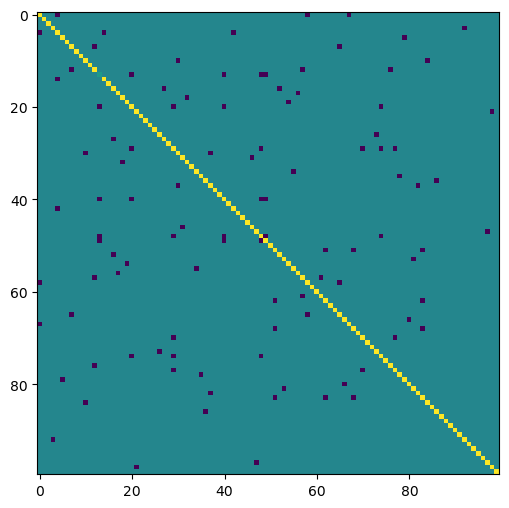

In [6]:
alpha = 0.85 # a typical damping factor used in PageRank
M = (1 - alpha) * (np.eye(A.shape[0]) - alpha * A)
print(M.shape)

plt.figure(figsize=(6, 6))
plt.imshow(M[:100, :100])


# Inverting a matrix

So far, we have taken for granted that we can easily invert a large matrix $\mathbf{A}$. Given a linear problem
$$
A \mathbf{x} = \mathbf{b}
$$
with $A \in \mathbb{R}^{N \times N}$, $\mathbf{x} \in \mathbb{R}^N$, and $\mathbf{b} \in \mathbb{R}^N$, we can solve for $\mathbf{x}$ by inverting $A$:
$$
\mathbf{x} = A^{-1} \mathbf{b}
$$

#### How would we do this by hand?

Gauss-Jordan elimination: perform a series of operations on both the left and the right hand sides of our equation (changing both $A$ and $\mathbf{b}$), until the left side of the equation is triangular in form. Because Gauss-Jordan elimination consists of a series of row-wise addition and subtraction operations, we can think of the process as writing each row vector in terms of some linear combination of row vectors, making the whole process expressible as a matrix $M$

$$
(M A) \mathbf{x} = M \mathbf{b} \\
$$
$$
U \mathbf{x} = M \mathbf{b} \\
$$
where we have defined the upper-triangular matrix $U \equiv MA$. This confirms our intuition that the time complexity of Gauss-Jordan elimination is $\sim\mathcal{O}(N^3)$, since that's the time complexity of multiplying two $N \times N$ matrices.

#### Why do we want triangular matrices?

If we can reduce our matrix $A$ to upper-triangular form, then we can quickly solve for $\mathbf{x}$ using forward substitution. This should take $\sim\mathcal{O(N^2)}$ operations if $A \in \mathbb{R}^{N \times N}$

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/triangular.png" width="400"/>


We can implement a forward substitution algorithm that takes advantage of the fact that the matrix is triangular. To simplify our notation, we will assum that $A$ is lower-triangular, so that the first row has only one non-zero element at $A_{0,0}$. We can theniterate over rows of $A$ in order to find the elements of the solution vector $\mathbf{x} \in \mathbb{R}^N$ one-by-one. For example, the first element is simplygiven by
$$
    x_0 = \frac{b_0}{A_{0,0}}
$$

The second element is given by
$$
    x_1 = \frac{b_1 - A_{1,0} x_0}{A_{1,1}}
$$


and so on. We can therefore write a general algorithm for forward substitution as 

$$
    x_i = \frac{b_i - \sum_{j=0}^{i-1} A_{i,j} x_j}{A_{i,i}}
$$

Notice how the number of operations scales with the number of non-zero elements in the row. We can apply the same approach to an upper-triangular matrix, but we would need to iterate over the rows in reverse order.





In [ ]:

def solve_tril(a, b):
    """
    Given a triangular matrix, solve using forward subtitution

    Args:
        a (np.ndarray): A lower triangular matrix
        b (np.ndarray): A vector

    Returns:
        x (np.ndarray): The solution to the system
    """
    n = a.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(a[i, :i], x[:i])) / a[i, i]
    return x
    
## Make a random lower triangular matrix
a = np.tril(np.random.random((10, 10)))
b = np.random.random(10)

print(np.linalg.solve(a, b))
print(solve_tril(a, b))

# Check that the numpy and our implementation give the same result
print(np.allclose(np.linalg.solve(a, b), solve_tril(a, b)))
# print(np.all(np.linalg.solve(a, b) == solve_tril(a, b)))
# np.sum(np.abs(np.linalg.solve(a, b) - solve_tril(a, b))) < 1e-14


[   2.79707624   -2.18975392   53.23153183  -45.2687191    30.5757885
 -655.20868552  537.77417227  188.26440703 -566.85239614  -94.10449712]
[   2.79707624   -2.18975392   53.23153183  -45.2687191    30.5757885
 -655.20868552  537.77417227  188.26440703 -566.85239614  -94.10449712]
True


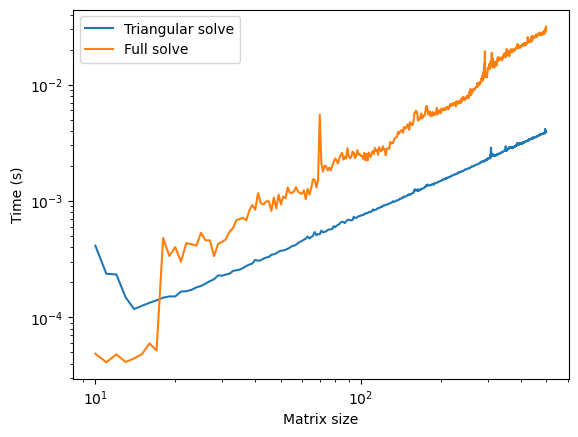

In [31]:
import timeit

all_times1, all_times2 = list(), list()
nvals = np.arange(10, 500)
for n in nvals:
    ## Upper triangular solve
    a = np.tril(np.random.random((n, n)))
    b = np.random.random(n)
    all_reps = [timeit.timeit("solve_tril(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times1.append(np.mean(all_reps))

    ## Full solve
    a = np.random.random((n, n))
    b = np.random.random(n)
    all_reps = [timeit.timeit("np.linalg.solve(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times2.append(np.mean(all_reps))

plt.loglog(nvals, all_times1, label="Triangular solve")
plt.loglog(nvals, all_times2, label="Full solve")
plt.xlabel("Matrix size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

We can see that the runtime complexity is $\sim\mathcal{O}(N^2)$ for the triangular solve, which makes sense because we only need to access each element of $A$ once, and there are $N(N-1)/2$ non-zero elements in $A$.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## To invert a full matrix, we first need reach triangular form

We know that we want to modify our full matrix equation 
$$
A \mathbf{x} = \mathbf{b}
$$ 
using a Gauss-Jordan elimination procedure, which we know has the form of a matrix multiplication
$$
M A \mathbf{x} = M \mathbf{b}
$$ 
We define $U \equiv M A$, and we know that if can reduce $U$ to upper-triangular form, then we can solve for $\mathbf{x}$ using forward substitution in $\sim\mathcal{O}(N^2)$ operations.
$$
U \mathbf{x} = M \mathbf{b}
$$
But what is the form of $M$? 

**Our key insight is that the Gaussian elimination matrix $M$ for a full matrix inversion turns is a triangular matrix.** Moreover, because the inverse of a triangular matrix is also a triangular matrix (this can be shown by writing out the algebraic terms in the matrix multiplication algebra for $U^{-1} U = I$), we therefore write a transformed version of our problem
$$
    U \mathbf{x} = M \mathbf{b}
$$
defining $M \equiv L^{-1}$, we arrive at the celebrated LU matrix factorization 
$$
    L U \mathbf{x} = \mathbf{b}
$$
where $L$ is a lower triangular matrix, and $U$ is an upper triangular matrix.

We can therefore solve for $\mathbf{x}$ by introducing an intermediate variable $\mathbf{h} \equiv U \mathbf{x}$, and then $\mathbf{x}$
$$
LU \mathbf{x} = \mathbf{b} \\
L \mathbf{h} = \mathbf{b} \\
\mathbf{x} = U^{-1} \mathbf{h}
$$

If we can find the LU form, exactly solving the linear problem consists of two steps, each of which has a time complexity of $\sim\mathcal{O}(N^2)$:
1. Solve the equation $\mathbf{h} = L^{-1} \mathbf{b}$. Since $L$ is a triangular matrix, this can be performed using substitution
2. Solve the equation $\mathbf{x} = U^{-1} \mathbf{h}$. Since $U$ is also triangular, this inverse can also be computed using substitution

The hard part, then, will be to find the LU form in the first place. This is equivalent to finding the Gaussian elimination matrix for the full matrix inversion problem.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## About LU factorization

An iterative implementation of $LU$ factorization uses Gauss-Jordan elimination in a principled order. We first eliminate the first column of the matrix, then the second column, and so on. A more sophisticated algorithm, Crout's method with pivoting, performs optimal order of decomposition based on the specific values present in a given row or column. However, our approach is matrix agnostic, and so we will not implement pivoting.

Decomposition into L and U is $\sim \mathcal{O}(N^3)$ for an $N \times N$ matrix, meaning that it has the same time complexity as matrix-matrix multiplication.

+ Given a matrix $A$ and target $\mathbf{b}$, what is the overall runtime to find $\mathbf{x}$?


# The LU decomposition algorithm

1. Set $L = I$ and $U = A$ (the input matrix)

2. For each column $j$ in $U$:
    1. Choose the pivot element $U_{jj}$, corresponding to the diagonal element in the $j^{th}$ column
    2. For each row $i$ *below* the pivot:
        1. Find the multiplier $L_{ij} = U_{ij} / U_{jj}$
        2. Subtract $L_{ij} \times$ the *entire* $j$ th row from the $i^{th}$ row in $U$
        3. Store $L_{ij}$ in the $i^{th}$ row of $L$

In the context of the LU decomposition algorithm, the 'pivot' refers to the element in the current column, denoted as $U_{jj}$, that we are processing in the outer loop. The pivot serves as a divisor to find the multipliers $L_{ij}$ which are then used to eliminate the elements below the pivot, making them zero to carve out an upper triangular matrix $U$.

Simultaneously, these multipliers are stored in the lower triangular matrix $L$. Essentially, we are utilizing the pivot to find scalar values that can help perform row operations to systematically zero out elements below the diagonal in $U$, while building up the $L$ matrix. We can see that there are three nested loops, which means that the time complexity of the LU decomposition algorithm is $\sim \mathcal{O}(N^3)$.

In [11]:
class LinearSolver:
    """
    Solve a linear matrix equation via LU decomposition (naive algorithm)
    """
    def __init__(self):
        # Run a small test upon construction
        self.test_lu()

    def lu(self, a):
        """Perform LU factorization of a matrix"""
        n = a.shape[0]
        L, U = np.identity(n), np.copy(a)
        for i in range(n):
            factor = U[i+1:, i] / U[i, i] # the multiplier for the current row
            L[i + 1:, i] = factor
            U[i + 1:] -= factor[:, None] * U[i]
        return L, U
    
    # A unit test of a single class method
    def test_lu(self):
        """A small test method that the factorization is correct"""
        X = np.random.random((10, 10))
        L, U = self.lu(X)
        assert np.allclose(X, L @ U), "LU decomposition failed"

    def forward_substitution(self, L, b):
        """Solve a lower triangular matrix equality of the form Lx = b for x"""
        n = L.shape[0]
        y = np.zeros(n)
        y[0] = b[0] / L[0, 0]
        for i in range(1, n):
            y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        return y
        
    def backward_substitution(self, U, b):
        """Solve an upper triangular matrix equality of teh form Ux = b for x"""
        n = U.shape[0]
        y = np.zeros(n)
        y[-1] = b[-1] / U[-1, -1]
        for i in range(n-2, -1, -1):
            y[i] = (b[i] - np.dot(U[i,i+1:], y[i+1:])) / U[i,i]
        return y
        
    def solve(self, X, b):
        L, U = self.lu(X)
        self.L, self.U = L, U

        # Intermediate variable
        h = self.forward_substitution(L, b)
        
        return self.backward_substitution(U, h)

        
        
        
# Construct a random linear problem
A = np.random.rand(4, 4)
b = np.random.rand(4)

model = LinearSolver()
print(model.solve(A, b))

# Solve the linear problem using the numpy built-in solver
print(np.linalg.solve(A, b))

print(np.allclose(model.solve(A, b), np.linalg.solve(A, b) ))

[ 1.33142238 -2.12393529  1.09356597  0.6981975 ]
[ 1.33142238 -2.12393529  1.09356597  0.6981975 ]
True


### Applying LU Decomposition of orthogonal basis sets

A Hadamard matrix is a square matrix comprising a complete collection of length $N$ mutually-orthogonal vectors with all elements equal to either $+1$ or $-1$. We can convert any complete orthonormal basis to a Hadamard matrix by ordering the vectors systematically, and substituting $0$ and $1$ for $\pm 1$ with a recursive rule. The recursive rule to generate a $2^n \times 2^n$ Hadamard matrix is
$$
H_{2n} = \begin{pmatrix}
    H_n & H_n \\
    H_n & -H_n
\end{pmatrix}
$$
where the base case is $H_1 = 1$. We can build this matrix bottom-up using dynamic programming, or top-down using recursion.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

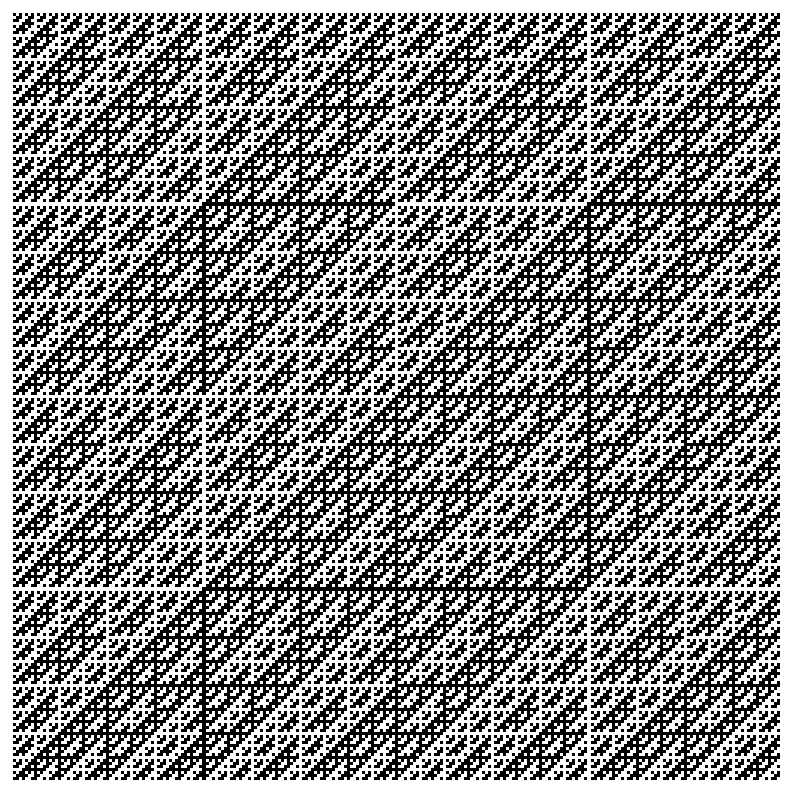

In [8]:
def hadamard(n):
    """
    Create a Hadamard matrix of size n using recursion
    """
    if n == 1:
        return np.array([[1]])
    else:
        H = hadamard(n // 2)
        return np.block([[H, H], [H, -H]])

def hadamard(n):
    """
    Create a Hadamard matrix of size  using dynamic programming
    """
    H = np.array([[1.]])
    for i in range(int(np.log2(n))):
        H = np.block([[H, H], [H, -H]])
    return H

plt.figure(figsize=(10, 10))
a = hadamard(2**8).astype(float)
# a = hadamard(2**).astype(float)
plt.imshow(a, cmap='gray')
plt.axis('off')
        

We can verify that the Hadamard matrix is orthogonal by computing its condition number, $\kappa(H) = \|H\| \|H^{-1}\|$.

In [9]:
np.linalg.cond(a)

np.float64(1.0000000000000024)

Since all rows and columns have inner product zero with each other, the matrix is orthogonal, and so the condition number is the lowest possible value of 1. Recall that the condition number of a random $N \times N$ matrix is $\sim N$.

We can see that the Hadamard matrix has unique structure due to its self-similar construction. We can highlight this structure by decomposing the Hadamard matrix into its $L$ and $U$ factors.

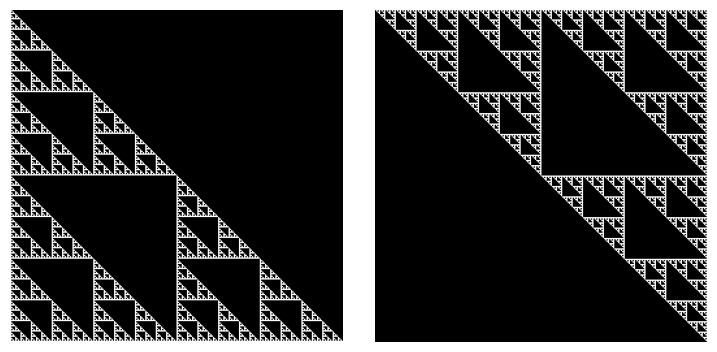

In [12]:

ll, uu = model.lu(a)


plt.figure(figsize=(9, 4.5))
plt.subplot(121)
plt.imshow(ll, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(uu.astype(bool), cmap='gray')
plt.axis('off')
## show plots closer together
plt.subplots_adjust(wspace=0.1)


We can see that the $L$ and $U$ matrices are both fractal matrices known as the Sierpinski triangle.

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Applying PageRank to the coauthorship graph

Now that we have a method for inverting a matrix, we can now apply the PageRank algorithm to the coauthorship graph. Recall that the PageRank algorithm is a random walk algorithm that can be written as a matrix inversion problem:

$$
    R = \mathbf{M}^{-1} \mathbb{1}
$$
where $\mathbf{M} \equiv (1 - \alpha) (I - \alpha A)$.

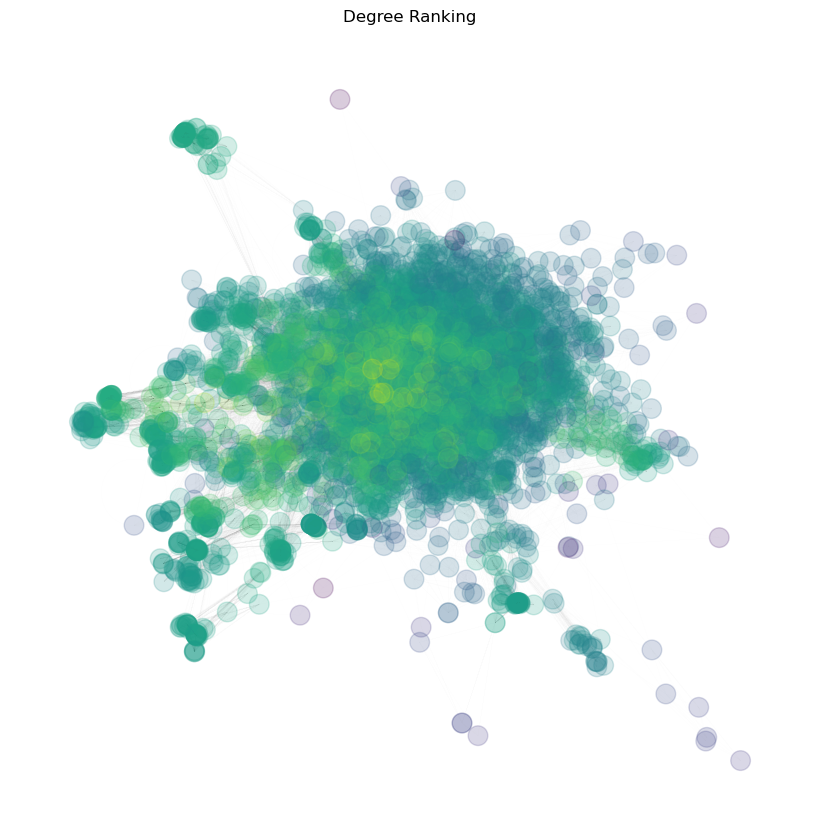

Condition number of M: 3808.383285542044


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_30515/3448364456.py:36: RuntimeWarning: invalid value encountered in log10
  nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank1),


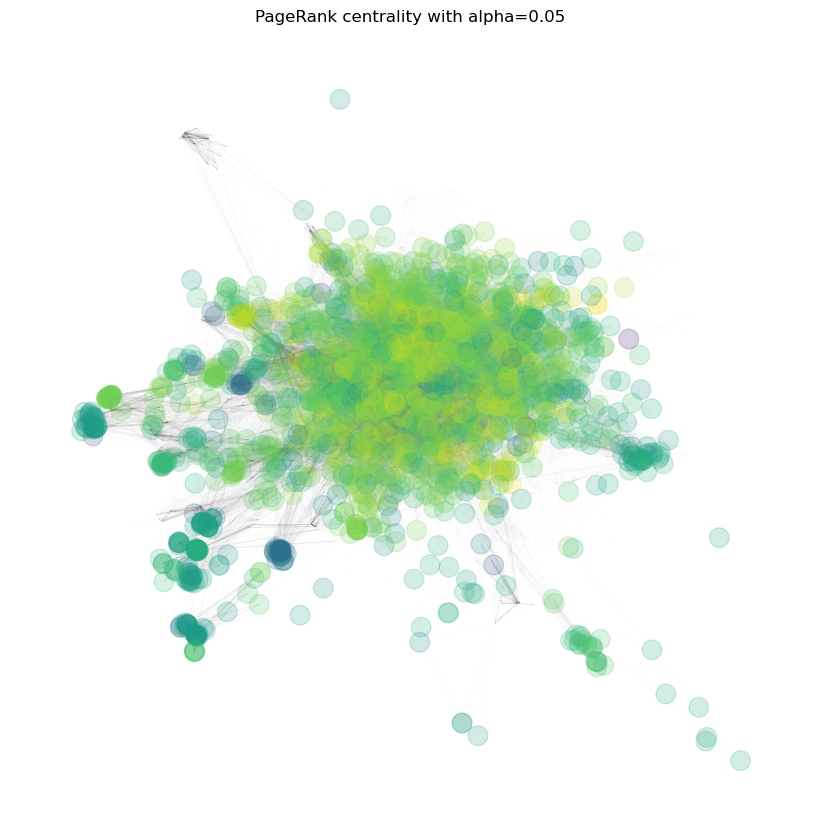

Condition number of M: 112286.22458188192


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_30515/3448364456.py:44: RuntimeWarning: invalid value encountered in log10
  nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank2),


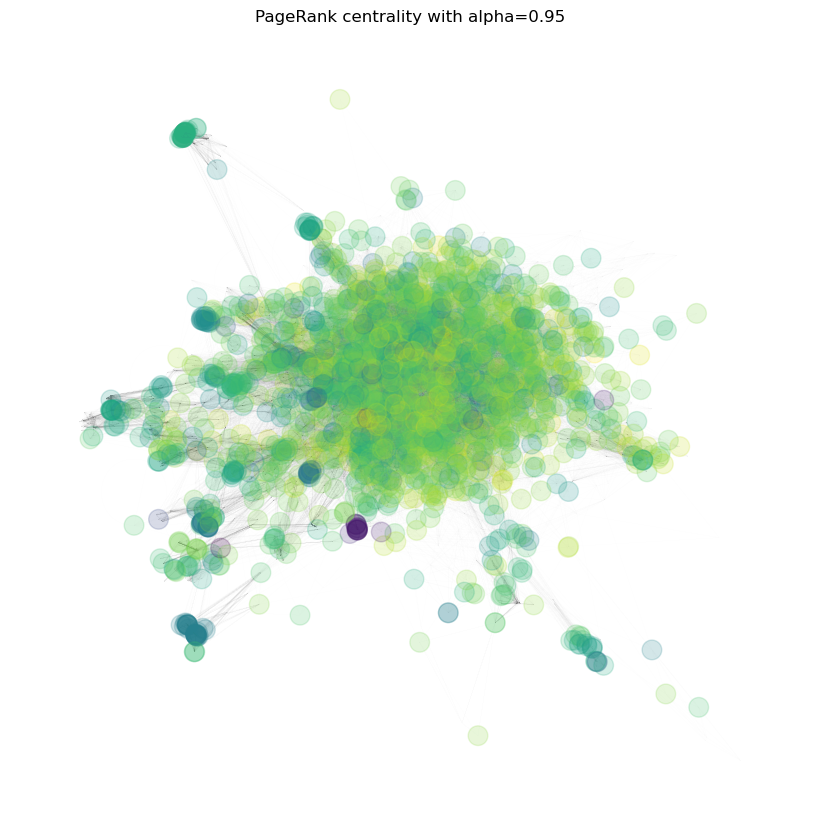

In [63]:
A = nx.adjacency_matrix(g2).todense() # get the binary adjacency matrix of the graph

def find_pagerank(A, alpha=0.85, verbose=False):
    """
    Find the PageRank of a graph using matrix inversion

    Args:
        A (np.ndarray): The adjacency matrix of the graph
        alpha (float): The damping factor. The default value is 0.85

    Returns:
        page_rank (np.ndarray): The PageRank of each node
    """
    M = (1 - alpha) * (np.eye(A.shape[0]) - alpha * A)

    if verbose:
        print(f"Condition number of M: {np.linalg.cond(M)}", flush=True)

    ## use our LU solver to solve for the PageRank
    # page_rank = np.linalg.inv(M) @ np.ones(M.shape[0])
    l, u = LinearSolver().lu(M)
    Minv = np.linalg.inv(u) @ np.linalg.inv(l)
    page_rank = Minv @ np.ones(M.shape[0])

    return page_rank


plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(rank_degree), 
        edge_color='gray', width=0.02, cmap='viridis', alpha=0.2)
plt.title(f"Degree Ranking")
plt.show()

page_rank1 = find_pagerank(A, alpha=0.05, verbose=True)
plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank1), 
        edge_color='gray', width=0.02, cmap='viridis', alpha=0.2)
plt.title(f"PageRank centrality with alpha=0.05")
plt.show()


page_rank2 = find_pagerank(A, alpha=0.99, verbose=True)
plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank2), 
        edge_color='gray', width=0.02, cmap='viridis', alpha=0.2)
plt.title(f"PageRank centrality with alpha=0.95")
plt.show()


We can see that high values of $\alpha$ cause the PageRank algorithm to look more like the degree distribution. This emphasizes larger subnetworks and and more highly-connected nodes. Conversely, low values of $\alpha$ cause the PageRank algorithm to converge to something closer to a uniform distribution over all nodes. The effect of the damping factor $\alpha$ is to control the trade-off between the random walk limit, which samples the well-connected nodes better, and the limit in which all nodes are sampled with equal probability. The latter case helps sample rarer nodes more frequently, at the expense of accurately representing the degree distribution for higher-degree nodes.

<br>
<br>
<br>
<br>
<br>
<br>
<br>